
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online [![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/v0.17?urlpath=lab/tree/cta_data_analysis.ipynb)
- You can contribute with your own notebooks in this
[GitHub repository](https://github.com/gammapy/gammapy/tree/master/tutorials).
- **Source files:**
[cta_data_analysis.ipynb](../_static/notebooks/cta_data_analysis.ipynb) |
[cta_data_analysis.py](../_static/notebooks/cta_data_analysis.py)
</div>


# CTA data analysis with Gammapy

## Introduction

**This notebook shows an example how to make a sky image and spectrum for simulated CTA data with Gammapy.**

The dataset we will use is three observation runs on the Galactic center. This is a tiny (and thus quick to process and play with and learn) subset of the simulated CTA dataset that was produced for the first data challenge in August 2017.


## Setup

As usual, we'll start with some setup ...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
!gammapy info --no-envvar --no-system


Gammapy package:

	version                : 0.17       
	path                   : /Users/terrier/Code/gammapy-dev/gammapy-docs/build/v0.17/gammapy/gammapy 


Other packages:

	numpy                  : 1.18.1     
	scipy                  : 1.4.1      
	astropy                : 4.0        
	regions                : 0.4        
	click                  : 7.1.1      
	yaml                   : 5.1.2      
	IPython                : 7.13.0     
	jupyterlab             : 2.0.1      
	matplotlib             : 3.1.2      
	pandas                 : 0.25.3     
	healpy                 : 1.13.0     
	iminuit                : 1.3.8      
	sherpa                 : 4.12.0     
	naima                  : 0.9.1      
	emcee                  : 2.2.1      
	corner                 : 2.0.1      
	parfive                : 1.0.0      



In [3]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.convolution import Gaussian2DKernel
from regions import CircleSkyRegion
from gammapy.modeling import Fit
from gammapy.data import DataStore
from gammapy.datasets import (
    Datasets,
    FluxPointsDataset,
    SpectrumDataset,
    MapDataset,
)
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    GaussianSpatialModel,
)
from gammapy.maps import MapAxis, WcsNDMap, WcsGeom
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
)
from gammapy.estimators import TSMapEstimator, FluxPointsEstimator
from gammapy.estimators.utils import find_peaks
from gammapy.visualization import plot_spectrum_datasets_off_regions

In [4]:
# Configure the logger, so that the spectral analysis
# isn't so chatty about what it's doing.
import logging

logging.basicConfig()
log = logging.getLogger("gammapy.spectrum")
log.setLevel(logging.ERROR)

## Select observations

A Gammapy analysis usually starts by creating a `~gammapy.data.DataStore` and selecting observations.

This is shown in detail in the other notebook, here we just pick three observations near the galactic center.

In [5]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/cta-1dc/index/gps")

In [6]:
# Just as a reminder: this is how to select observations
# from astropy.coordinates import SkyCoord
# table = data_store.obs_table
# pos_obs = SkyCoord(table['GLON_PNT'], table['GLAT_PNT'], frame='galactic', unit='deg')
# pos_target = SkyCoord(0, 0, frame='galactic', unit='deg')
# offset = pos_target.separation(pos_obs).deg
# mask = (1 < offset) & (offset < 2)
# table = table[mask]
# table.show_in_browser(jsviewer=True)

In [7]:
obs_id = [110380, 111140, 111159]
observations = data_store.get_observations(obs_id)

In [8]:
obs_cols = ["OBS_ID", "GLON_PNT", "GLAT_PNT", "LIVETIME"]
data_store.obs_table.select_obs_id(obs_id)[obs_cols]

OBS_ID,GLON_PNT,GLAT_PNT,LIVETIME
,deg,deg,s
int64,float64,float64,float64
110380,359.9999912037958,-1.299995937905366,1764.0
111140,358.4999833830074,1.3000020211954284,1764.0
111159,1.5000056568267741,1.299940468335294,1764.0


## Make sky images

### Define map geometry

Select the target position and define an ON region for the spectral analysis

In [9]:
axis = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0), npix=(500, 400), binsz=0.02, frame="galactic", axes=[axis]
)
geom

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (500, 400, 9)
	ndim       : 3
	frame      : galactic
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 10.0 deg x 8.0 deg

### Compute images

Exclusion mask currently unused. Remove here or move to later in the tutorial?

In [10]:
target_position = SkyCoord(0, 0, unit="deg", frame="galactic")
on_radius = 0.2 * u.deg
on_region = CircleSkyRegion(center=target_position, radius=on_radius)

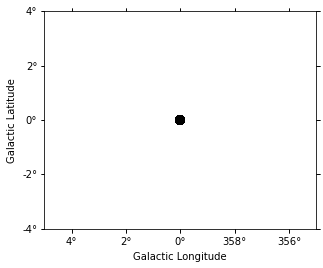

In [11]:
exclusion_mask = geom.to_image().region_mask([on_region], inside=False)
exclusion_mask = WcsNDMap(geom.to_image(), exclusion_mask)
exclusion_mask.plot();

In [12]:
%%time
stacked = MapDataset.create(geom=geom)
maker = MapDatasetMaker(selection=["counts", "background", "exposure", "psf"])
maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=2.5 * u.deg)

for obs in observations:
    cutout = stacked.cutout(obs.pointing_radec, width="5 deg")
    dataset = maker.run(cutout, obs)
    dataset = maker_safe_mask.run(dataset, obs)
    stacked.stack(dataset)

CPU times: user 3.81 s, sys: 770 ms, total: 4.58 s
Wall time: 4.62 s


In [13]:
# The maps are cubes, with an energy axis.
# Let's also make some images:
dataset_image = stacked.to_image()

images = {
    "counts": dataset_image.counts.get_image_by_idx((0,)),
    "exposure": dataset_image.exposure.get_image_by_idx((0,)),
    "background": dataset_image.background_model.map.get_image_by_idx((0,)),
}

images["excess"] = images["counts"] - images["background"]

/Users/terrier/Code/gammapy-dev/gammapy-docs/build/v0.17/gammapy/gammapy/irf/psf_map.py:317: RuntimeWarning: invalid value encountered in true_divide
  psf_data = exp_weighed.data * self.psf_map.data / exposure.data


### Show images

Let's have a quick look at the images we computed ...

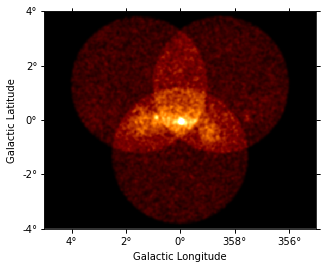

In [14]:
images["counts"].smooth(2).plot(vmax=5);

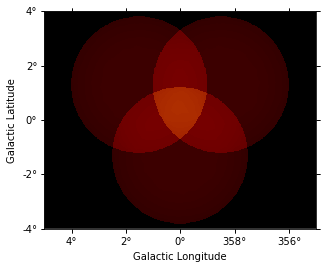

In [15]:
images["background"].plot(vmax=5);

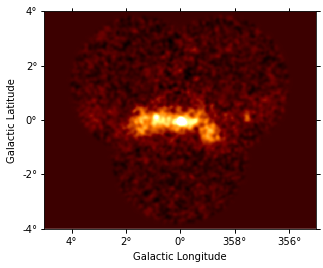

In [16]:
images["excess"].smooth(3).plot(vmax=2);

## Source Detection

Use the class `~gammapy.estimators.TSMapEstimator` and `~gammapy.estimators.utils.find_peaks` to detect sources on the images. We search for 0.1 deg sigma gaussian sources in the dataset.

In [17]:
spatial_model = GaussianSpatialModel(sigma="0.1 deg")
spectral_model = PowerLawSpectralModel(index=2)
model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)

In [18]:
%%time
ts_image_estimator = TSMapEstimator(model)
images_ts = ts_image_estimator.run(dataset_image)
print(images_ts.keys())

/Users/terrier/Code/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


dict_keys(['ts', 'sqrt_ts', 'flux', 'flux_err', 'flux_ul', 'niter'])
CPU times: user 13.8 s, sys: 239 ms, total: 14 s
Wall time: 14.1 s


In [19]:
sources = find_peaks(images_ts["sqrt_ts"], threshold=6)
sources

value,x,y,ra,dec
,,,deg,deg
float32,int64,int64,float64,float64
33.708,253,197,266.41208,-29.02198
16.935,207,205,266.80079,-28.15278
12.358,214,198,266.85440,-28.34505
12.351,273,196,266.19254,-29.37365
11.921,217,198,266.81908,-28.39638
11.887,277,197,266.12496,-29.43139
11.654,202,193,267.09247,-28.19131
11.635,217,196,266.85798,-28.41709


In [20]:
source_pos = SkyCoord(sources["ra"], sources["dec"])
source_pos

<SkyCoord (ICRS): (ra, dec) in deg
    [(266.41208417, -29.02197675), (266.80078569, -28.15277706),
     (266.85440284, -28.34505079), (266.19254245, -29.37364637),
     (266.81908408, -28.39637563), (266.12496388, -29.43138591),
     (267.09246923, -28.19130928), (266.85798491, -28.4170929 ),
     (266.93219577, -28.38645429), (266.23290288, -29.27792918),
     (266.12135787, -30.08650777), (267.26396225, -27.74559804),
     (267.06616784, -27.80367473), (267.01576857, -27.80014032),
     (267.16320789, -27.73865467), (266.82209403, -28.58503656),
     (267.06246648, -27.73163821), (267.10117415, -27.75228685),
     (266.62593456, -28.71452286), (266.98070633, -27.85150651),
     (267.12449328, -27.71802333), (266.62670235, -28.59790578),
     (266.74419779, -28.54357072), (266.87285832, -28.58864192),
     (267.32210113, -27.65986372), (267.28338443, -27.63927661),
     (267.10490183, -27.82432239), (266.00310432, -29.41311646),
     (266.66218198, -28.54663069), (266.22434599, -30.0

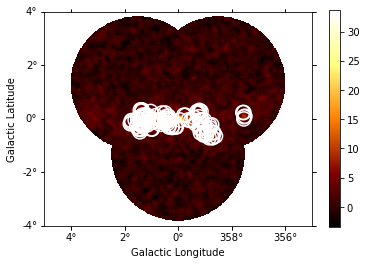

In [21]:
# Plot sources on top of significance sky image
images_ts["sqrt_ts"].plot(add_cbar=True)

plt.gca().scatter(
    source_pos.ra.deg,
    source_pos.dec.deg,
    transform=plt.gca().get_transform("icrs"),
    color="none",
    edgecolor="white",
    marker="o",
    s=200,
    lw=1.5,
);

## Spatial analysis

See other notebooks for how to run a 3D cube or 2D image based analysis.

## Spectrum

We'll run a spectral analysis using the classical reflected regions background estimation method,
and using the on-off (often called WSTAT) likelihood function.

In [22]:
e_reco = np.logspace(-1, np.log10(40), 40) * u.TeV
e_true = np.logspace(np.log10(0.05), 2, 200) * u.TeV

dataset_empty = SpectrumDataset.create(
    e_reco=e_reco, e_true=e_true, region=on_region
)

In [23]:
dataset_maker = SpectrumDatasetMaker(
    containment_correction=False, selection=["counts", "aeff", "edisp"]
)
bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

In [24]:
%%time
datasets = []

for observation in observations:
    dataset = dataset_maker.run(
        dataset_empty.copy(name=f"obs-{observation.obs_id}"), observation
    )
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    datasets.append(dataset_on_off)

CPU times: user 3.94 s, sys: 258 ms, total: 4.2 s
Wall time: 4.21 s


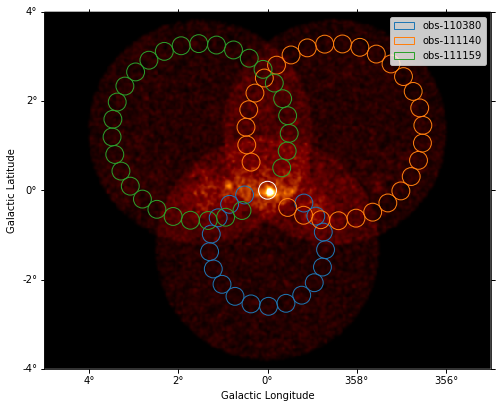

In [25]:
plt.figure(figsize=(8, 8))
_, ax, _ = images["counts"].smooth("0.03 deg").plot(vmax=8)

on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor="white")
plot_spectrum_datasets_off_regions(datasets, ax=ax)

### Model fit

The next step is to fit a spectral model, using all data (i.e. a "global" fit, using all energies).

In [26]:
%%time
spectral_model = PowerLawSpectralModel(
    index=2, amplitude=1e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV
)
model = SkyModel(spectral_model=spectral_model, name="source-gc")
for dataset in datasets:
    dataset.models = model

fit = Fit(datasets)
result = fit.run()
print(result)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 108
	total stat : 75.81

CPU times: user 885 ms, sys: 15 ms, total: 900 ms
Wall time: 941 ms


### Spectral points

Finally, let's compute spectral points. The method used is to first choose an energy binning, and then to do a 1-dim likelihood fit / profile to compute the flux and flux error.

In [27]:
# Flux points are computed on stacked observation
stacked_dataset = Datasets(datasets).stack_reduce(name="stacked")

print(stacked_dataset)

SpectrumDatasetOnOff
--------------------

  Name                            : stacked 

  Total counts                    : 441 
  Total predicted counts          : 433.82
  Total off counts                : 2278.00

  Total background counts         : 91.22

  Effective area min              : 1.88e+08 cm2
  Effective area max              : 4.64e+10 cm2

  Livetime                        : 5.29e+03 s

  Acceptance mean:                : 1.0

  Number of total bins            : 39 
  Number of fit bins              : 29 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 208.36

  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : source-gc
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : None
    Temporal model type       : None
    Parameters:
      index                   :   2.423              
   

In [28]:
e_edges = MapAxis.from_energy_bounds("1 TeV", "30 TeV", nbin=5).edges

stacked_dataset.models = model

fpe = FluxPointsEstimator(e_edges=e_edges, source="source-gc")
flux_points = fpe.run(datasets=[stacked_dataset])
flux_points.table_formatted

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,success,norm_err,norm_errp,norm_errn,norm_ul,sqrt_ts,ts,null_value,norm_scan [11],stat_scan [11],counts [1],dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64
1.362,1.002,1.852,1.598e-12,1.381e-12,1.828e-12,2.966e-12,0.882,3.705,True,0.113,0.127,0.119,1.146,10.896,118.712,0,0.200 .. 5.000,57.282 .. 359.241,83,1.410e-12,1.832e-12,1.804e-13,2.033e-13,1.901e-13
2.719,1.852,3.993,2.993e-13,6.568e-13,1.708e-12,2.213e-12,1.168,1.660,True,0.136,0.146,0.136,1.469,13.917,193.670,0,0.200 .. 5.000,99.764 .. 277.338,92,3.495e-13,4.397e-13,4.063e-14,4.359e-14,4.067e-14
5.429,3.993,7.382,5.605e-14,1.930e-13,1.018e-12,1.652e-12,1.208,3.418,True,0.312,0.226,0.201,1.681,9.520,90.629,0,0.200 .. 5.000,50.176 .. 123.817,43,6.772e-14,9.423e-14,1.747e-14,1.267e-14,1.129e-14
10.838,7.382,15.913,1.050e-14,9.180e-14,9.512e-13,1.233e-12,0.761,7.054,True,0.226,0.251,0.210,1.302,5.257,27.635,0,0.200 .. 5.000,17.512 .. 99.475,16,7.992e-15,1.367e-14,2.368e-15,2.636e-15,2.209e-15
21.636,15.913,29.419,1.966e-15,2.698e-14,5.671e-13,9.202e-13,0.564,2.889,True,0.331,0.409,0.294,1.511,2.536,6.431,0,0.200 .. 5.000,4.599 .. 37.773,4,1.108e-15,2.971e-15,6.501e-16,8.047e-16,5.781e-16


### Plot

Let's plot the spectral model and points. You could do it directly, but for convenience we bundle the model and the flux points in a `FluxPointDataset`:

In [29]:
flux_points_dataset = FluxPointsDataset(data=flux_points, models=model)

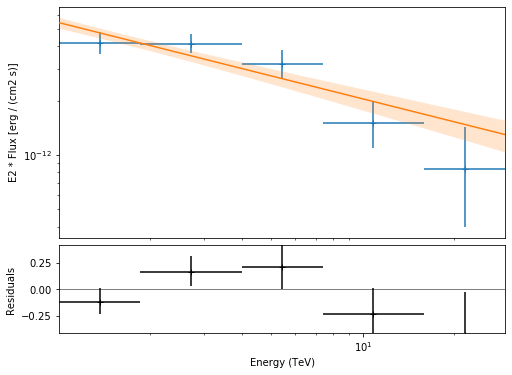

In [30]:
plt.figure(figsize=(8, 6))
flux_points_dataset.peek();

## Exercises

* Re-run the analysis above, varying some analysis parameters, e.g.
    * Select a few other observations
    * Change the energy band for the map
    * Change the spectral model for the fit
    * Change the energy binning for the spectral points
* Change the target. Make a sky image and spectrum for your favourite source.
    * If you don't know any, the Crab nebula is the "hello world!" analysis of gamma-ray astronomy.

In [31]:
# print('hello world')
# SkyCoord.from_name('crab')

## What next?

* This notebook showed an example of a first CTA analysis with Gammapy, using simulated 1DC data.
* Let us know if you have any question or issues!